In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ["KERAS_BACKEND"] = "torch"  # "jax" or "tensorflow" or "torch" 

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_io as tfio
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as transforms

import numpy as np 
import pandas as pd
from scipy import signal as sci_signal

from glob import glob
from tqdm import tqdm

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.colormaps['coolwarm']

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [30]:
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)
print("Pytorch:", torch.__version__)

Keras: 3.4.1
KerasCV: 0.9.0
Pytorch: 2.1.2+cpu


In [31]:
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

In [32]:
torch.manual_seed(CFG.seed)
BASE_PATH = '/kaggle/input/birdclef-2024'


In [33]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rwos
df.head(10)
#print(len(df))

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,XC134896.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC134896
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,XC164848.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC164848
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,XC175797.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC175797
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,XC207738.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC207738
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,XC209218.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC209218
5,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209219,XC209219.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC209219
6,asbfly,[],['clicks its bill'],42.5275,130.6920,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/267679,XC267679.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC267679
7,asbfly,[],"['call', 'male', 'song']",44.3602,132.7989,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/267680,XC267680.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC267680
8,asbfly,[],"['call', 'male', 'song']",44.3602,132.7989,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/267681,XC267681.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC267681
9,asbfly,[],['alarm call'],42.5275,130.6920,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/267682,XC267682.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC267682


In [34]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

In [ ]:
def oog2spec_via_scipy(audio_data):
    # handles NaNs
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)
    
    # to spec.
    frequencies, times, spec_data = sci_signal.spectrogram(
        audio_data, 
        fs=config.FS, 
        nfft=config.N_FFT, 
        nperseg=config.WIN_SIZE, 
        noverlap=config.WIN_LAP, 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= config.MIN_FREQ) & (frequencies <= config.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = np.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data

# Audio:


# Visualization:


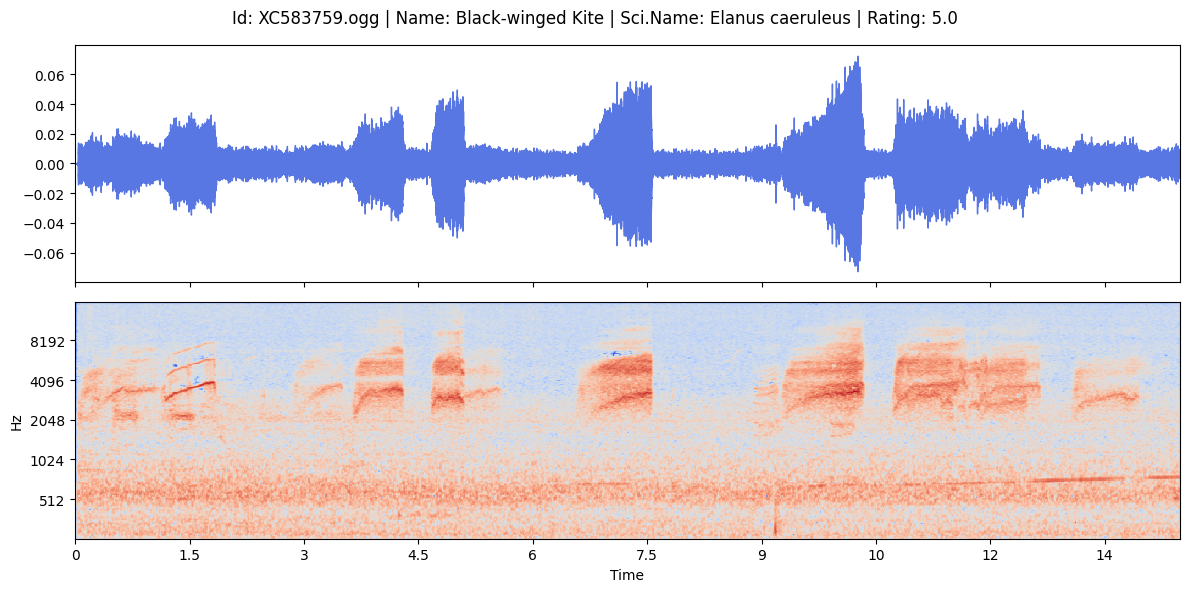

In [35]:
row = df.iloc[2000]

# Display audio
display_audio(row)

In [36]:
# Import required packages
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

Num Train: 19567 | Num Valid: 4892


In [37]:
def build_decoder(with_labels=True, dim=1024):
    #process and convert raw audio to 32-bit floating point tensor
    def get_audio(filepath):
        waveform,_ = torchaudio.load(filepath)
        if waveform.shape[0] > 1:  # stereo -> mono
            waveform = waveform[0:1, :]
        waveform = waveform.squeeze(0)
        return waveform

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = audio.shape[0]
        diff_len = abs(
            target_len - audio_len
        )  # find difference between target and audio length
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = torch.randint(0, diff_len+1, (1,), dtype=torch.int32)
            pad2 = diff_len - pad1
            audio = F.pad(audio, (pad1, pad2), mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = torch.randint(0, diff_len+1, (1,), dtype=torch.int32)
            audio = audio[idx : (idx + target_len)]
        return torch.reshape(audio, [target_len])

    def apply_preproc(spec):
        # Standardize
        mean = torch.mean(spec)
        std = torch.std(spec)
        spec = torch.where(std==0, spec - mean, (spec - mean) / std)

        # Normalize using Min-Max
        min_val = torch.min(spec)
        max_val = torch.max(spec)
        spec = torch.where(
            max_val - min_val == 0,
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = torch.tensor(target, dtype=torch.long)
        target = torch.nn.functional.one_hot(target, num_classes=CFG.num_classes).float()
        target = torch.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        # Load audio file
        audio = get_audio(path)
        # Crop or pad audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        # Audio to Spectrogram
        spec= transforms.MelSpectrogram(
            sample_rate=CFG.sample_rate,
            n_fft=CFG.nfft,
            hop_length=CFG.hop_length,
            n_mels=CFG.img_size[0]
        )
        # Apply normalization and standardization
        spec = apply_preproc(spec)
        # Spectrogram to 3 channel image (for imagenet)
        spec = torch.tile(spec[..., None], (1, 1, 3))
        spec = torch.reshape(spec, [*CFG.img_size, 3])
        return spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode

In [ ]:
def oog2spec_via_scipy(audio_data):
    # handles NaNs
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)
    
    # to spec.
    frequencies, times, spec_data = sci_signal.spectrogram(
        audio_data, 
        fs=config.FS, 
        nfft=config.N_FFT, 
        nperseg=config.WIN_SIZE, 
        noverlap=config.WIN_LAP, 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= config.MIN_FREQ) & (frequencies <= config.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = np.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data

In [38]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if torch.rand(1) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment

In [39]:
class AudioDataset(Dataset):
    def __init__(self, paths, labels=None, decode_fn=None, augment_fn=None, augment=False):
        self.paths = paths
        self.labels = labels
        self.decode_fn = decode_fn if decode_fn else build_decoder()
        self.augment_fn = augment_fn if augment_fn else build_augmenter()
        self.augment = augment
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if self.labels is None:
            path = self.paths[idx]
            feature = self.decode_fn(path)
            return feature
        else:
            path = self.paths[idx]
            label = self.labels[idx]
            feature, label = self.decode_fn(path, label)
            if self.augment:
                feature = self.augment_fn(feature)
            return feature, label


In [40]:
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_dataset = AudioDataset(train_paths, train_labels, build_decoder() , build_augmenter(), CFG.augment)
train_ds = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle = True,
        num_workers=4,
        pin_memory=True,
        drop_last=True  # Drop the last incomplete batch
    )
print(len(train_ds))

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_dataset = AudioDataset(valid_paths, valid_labels, build_decoder(), build_augmenter(), CFG.augment)
valid_ds = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        num_workers= 4,
        shuffle = True,
        pin_memory=True,
        drop_last=True  # Drop the last incomplete batch
)

305


In [41]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]), 
                     n_fft=CFG.nfft, 
                     hop_length=CFG.hop_length, 
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

In [42]:
batch = next(iter(train_ds))
plot_batch(batch, label2name=CFG.label2name)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_33/305042916.py", line 20, in __getitem__
    feature, label = self.decode_fn(path, label)
  File "/tmp/ipykernel_33/2125115959.py", line 67, in decode_with_labels
    return decode(path), label
  File "/tmp/ipykernel_33/2125115959.py", line 59, in decode
    spec = apply_preproc(spec)
  File "/tmp/ipykernel_33/2125115959.py", line 26, in apply_preproc
    mean = torch.mean(spec)
TypeError: mean(): argument 'input' (position 1) must be Tensor, not MelSpectrogram
